In [1]:
import numpy as np
import torch
import torch.nn as nn
import h5py as h5
import os
import sys
import pickle
sys.path.append("../")
from models import PracticalBNCNN, NormedBNCNN, DalesBNCNN, DalesSSCNN, SSCNN, BNCNN, PracticalBNCNN, DalesHybrid, DalesSkipBNCNN, SkipBNBNCNN
#import metrics
import matplotlib.pyplot as plt
from utils.deepretina_loader import loadexpt
from utils.physiology import Physio
import utils.intracellular as intracellular
import utils.batch_compute as bc
import utils.retinal_phenomena as rp
import utils.stimuli as stimuli
import pyret.filtertools as ft
import scipy
import re
import pickle
from tqdm import tqdm
import gc
import resource
import time
import math

def normalize(x):
    return (x-x.mean())/(x.std()+1e-7)

def retinal_phenomena_figs(bn_cnn):
    rp.step_response(bn_cnn)
    rp.osr(bn_cnn)
    rp.reversing_grating(bn_cnn)
    rp.contrast_adaptation(bn_cnn, .35, .05)
    rp.motion_anticipation(bn_cnn)
    
#If you want to use stimulus that isnt just boxes
def prepare_stim(stim, stim_type):
    if stim_type == 'boxes':
        return 2*stim - 1
    elif stim_type == 'flashes':
        stim = stim.reshape(stim.shape[0], 1, 1)
        return np.broadcast_to(stim, (stim.shape[0], 38, 38))
    elif stim_type == 'movingbar':
        stim = block_reduce(stim, (1,6), func=np.mean)
        stim = pyret.stimulustools.upsample(stim.reshape(stim.shape[0], stim.shape[1], 1), 5)[0]
        return np.broadcast_to(stim, (stim.shape[0], stim.shape[1], stim.shape[1]))
    elif stim_type == 'lines':
        stim_averaged = np.apply_along_axis(lambda m: np.convolve(m, 0.5*np.ones((2,)), mode='same'), 
                                            axis=1, arr=stim)
        stim = stim_averaged[:,::2]
        # now stack stimulus to convert 1d to 2d spatial stimulus
        return stim.reshape(-1,1,stim.shape[-1]).repeat(stim.shape[-1], axis=1)
    else:
        print("Invalid stim type")
        assert False
    
def index_of(arg, arr):
    for i in range(len(arr)):
        if arg == arr[i]:
            return i
    return -1

In [2]:
DEVICE = torch.device("cuda:0")
torch.cuda.empty_cache()

In [3]:
#Load data
# num_pots stores the number of cells per stimulus
# mem_pots stores the membrane potential
# psst, you can find the "data" folder in /home/grantsrb on deepretina server
# psssst, note the additional ../ added to each path in files

files = ['../data/bipolars_late_2012.h5', '../data/bipolars_early_2012.h5', '../data/amacrines_early_2012.h5', '../data/amacrines_late_2012.h5', '../data/horizontals_early_2012.h5', '../data/horizontals_late_2012.h5']
files = ["../" + name for name in files]
file_ids = []
for f in files:
    file_ids.append(re.split('_|\.', f)[0])
filter_length = 40
window_size = 2
num_pots = []
stims = dict()
mem_pots = dict()
keys_to_use = {"boxes"}
for fi in files:
    with h5.File(fi, 'r') as f:
        for k in f.keys():
            if k in keys_to_use:
                if k not in stims:
                    stims[k] = []
                if k not in mem_pots:
                    mem_pots[k] = []
                try:
                    stims[k].append(prepare_stim(np.asarray(f[k+'/stimuli']), k))
                    mem_pots[k].append(np.asarray(f[k]['detrended_membrane_potential'])[:, filter_length:])
                except:
                    print("stim error at", k)
        num = np.array(f['boxes/detrended_membrane_potential'].shape[0])
        num_pots.append(num)

In [5]:
grand_folder = "paralleldata_multidatabncnn"
exp_folder = "../training_scripts/"+grand_folder
_, model_folders, _ = next(os.walk(exp_folder))
for i,f in enumerate(model_folders):
    model_folders[i] = grand_folder + "/" + f

In [6]:
model_folders = sorted(model_folders)
print("\n".join(model_folders))

paralleldata_multidatabncnn/paralleldata_multidatabncnn_0_lr0.0075_l20.005
paralleldata_multidatabncnn/paralleldata_multidatabncnn_1_lr0.0075_l20.0005


In [7]:
file = "../training_scripts/"+model_folders[0]+"/test_epoch_0.pth"
try:
    with open(file, "rb") as fd:
        temp = torch.load(fd)
except:
    pass

temp['model']

ParallelDataBNCNN(
  (features): Sequential(
    (0): Conv2d(40, 8, kernel_size=(15, 15), stride=(1, 1))
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False)
    (4): ReLU()
    (5): Reshape()
    (6): Conv2d(8, 8, kernel_size=(11, 11), stride=(1, 1))
    (7): Flatten()
    (8): BatchNorm1d(5408, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (9): GaussianNoise(std=0.05, trainable=False)
    (10): ReLU()
  )
  (output_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=5408, out_features=5, bias=True)
      (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Softplus(beta=1, threshold=20)
    )
    (1): Sequential(
      (0): Linear(in_features=5408, out_features=5, bias=True)
      (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Softplus(beta=1, th

In [44]:
conv_layers = ['0.2', '0.8']

In [20]:
# Order matters here, must be same order as model trained on
datasets = ['15-10-07', '15-11-21a', "15-11-21b"] 
cells = ["all" for i in datasets]
stim_types = ['naturalscene', "whitenoise"]
norm_stats = [temp['norm_stats']['mean'], temp['norm_stats']['std']]

In [10]:
gc.collect()
max_mem_used = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
print("Memory Used: {:.2f} mb".format(max_mem_used / 1024))

Memory Used: 2923.45 mb


## Look at model performances

Using layers: 0.2 and 0.8
Folder: paralleldata_multidatabncnn/paralleldata_multidatabncnn_0_lr0.0075_l20.005
Final Loss: -7.449193842057279
Final Vals: [0.23499006477959483, -5.98912729856238, 20.243469667665977, -10.673199469169049, 10.645614175540686, -6.890330226626247]
Final Val Acc: [0.19849346280097963, 0.280996972322464, 0.2289971373975277, 0.28481895476579666, 0.2059096097946167, 0.23912561991635492]

Final Test Acc for 15-10-07 naturalscene: 0.4125021052297768

Final Test Acc for 15-10-07 whitenoise: 0.6686723165781039

Final Test Acc for 15-11-21a naturalscene: 0.507815939277386

Final Test Acc for 15-11-21a whitenoise: 0.6255117790145034

Final Test Acc for 15-11-21b naturalscene: 0.4535328347482332

Final Test Acc for 15-11-21b whitenoise: 0.5043822776411317


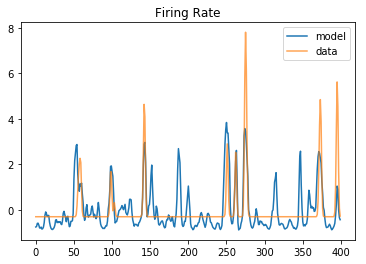

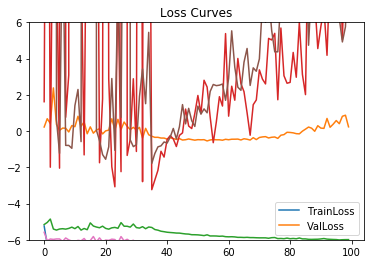

  0%|          | 0/10 [00:00<?, ?it/s]

For layer 0


100%|██████████| 10/10 [00:00<00:00, 86.45it/s]
51it [00:00, 220.29it/s]


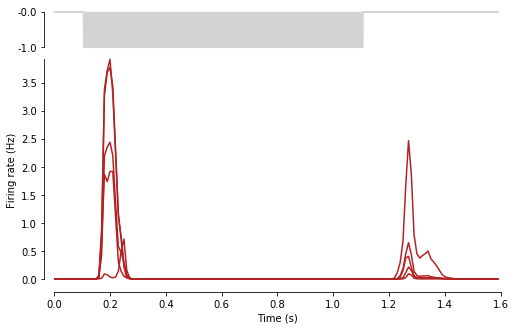

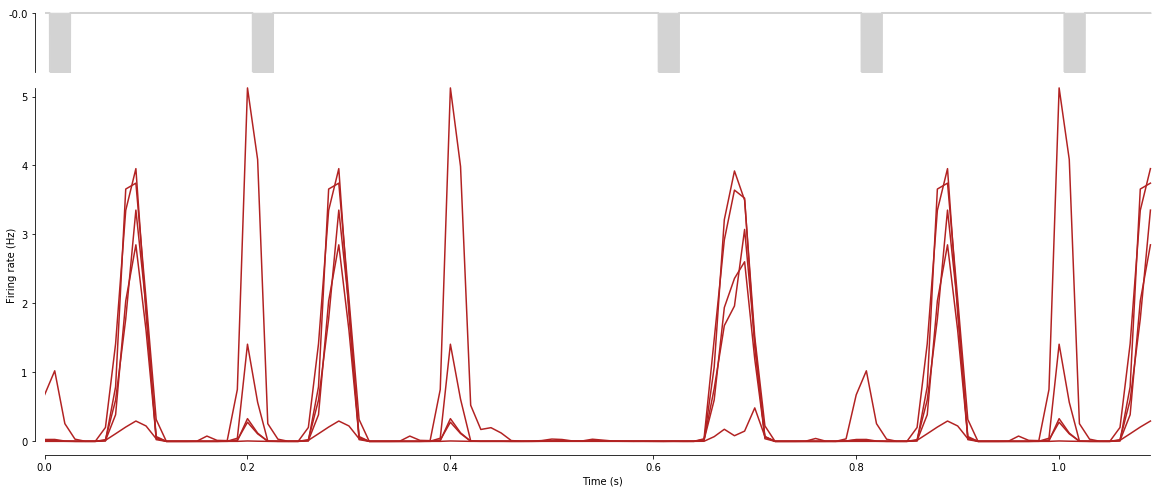

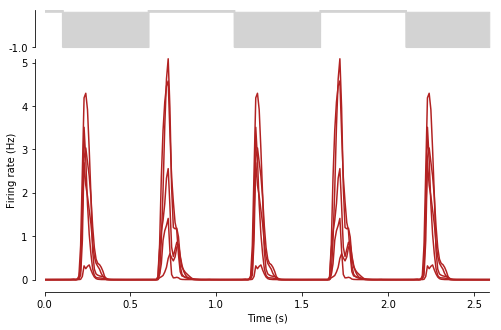

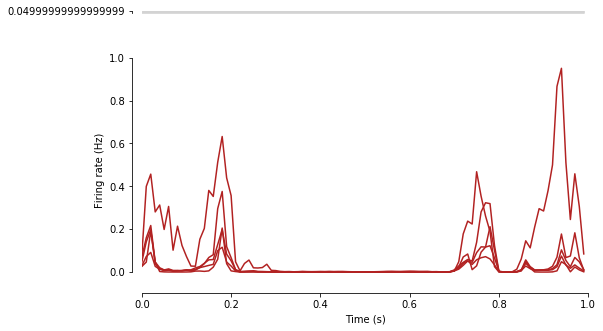

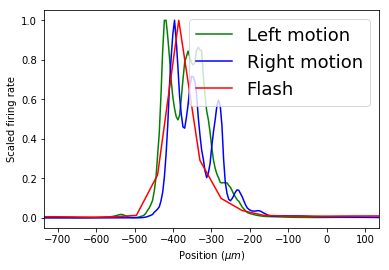

  0%|          | 0/10 [00:00<?, ?it/s]

For layer 1


100%|██████████| 10/10 [00:00<00:00, 92.54it/s]
51it [00:00, 225.09it/s]


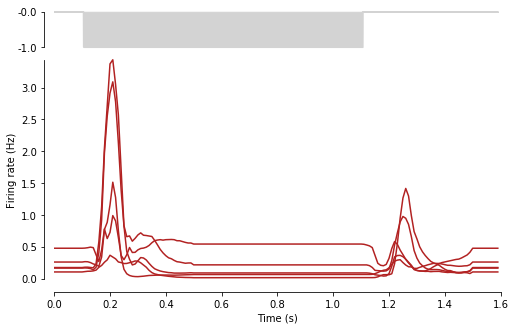

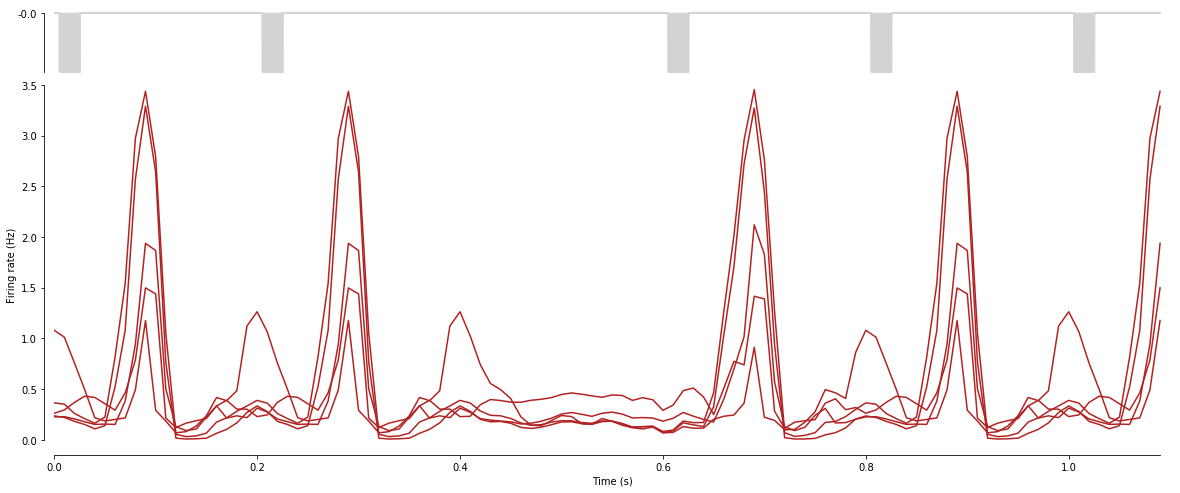

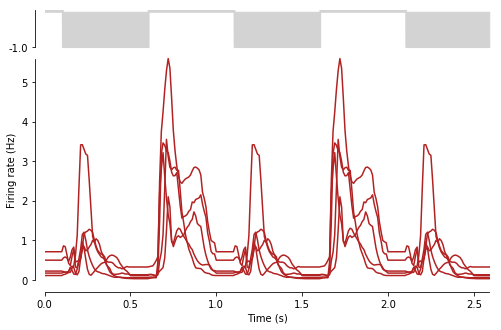

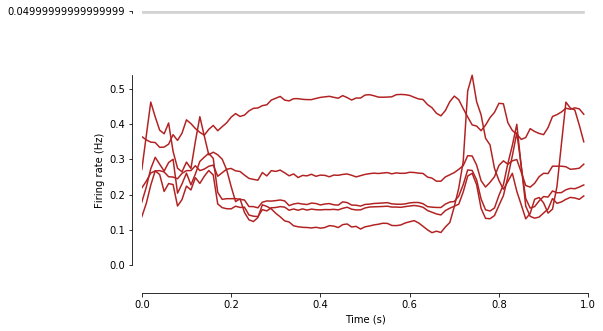

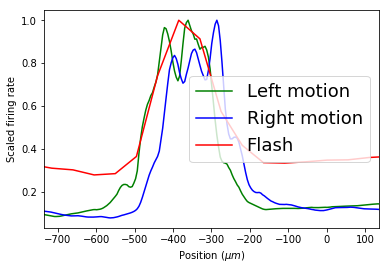

  0%|          | 0/10 [00:00<?, ?it/s]

For layer 2


100%|██████████| 10/10 [00:00<00:00, 84.48it/s]
51it [00:00, 221.41it/s]


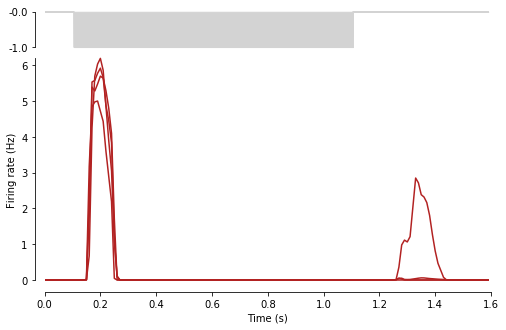

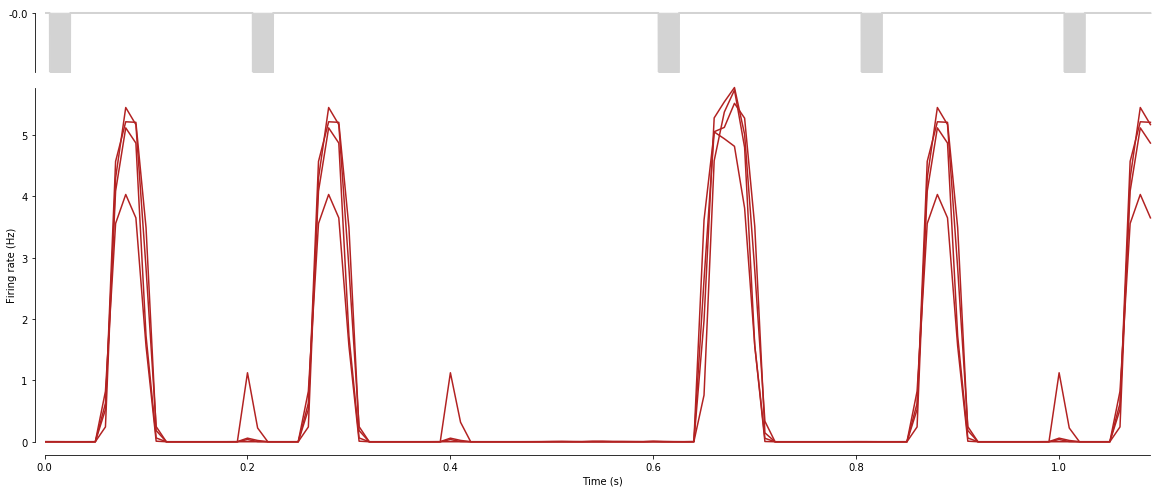

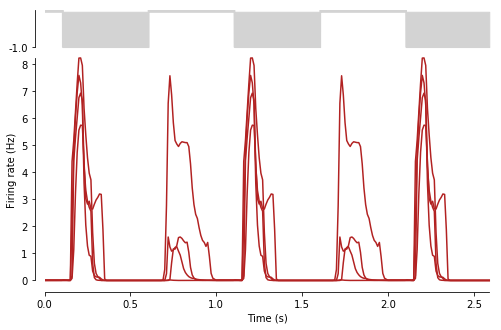

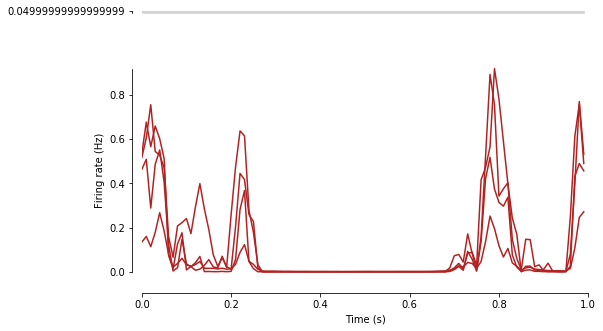

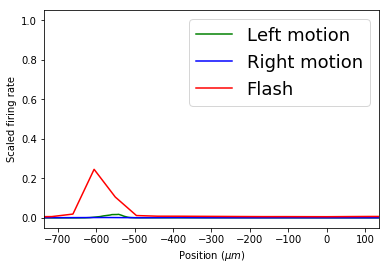

  0%|          | 0/10 [00:00<?, ?it/s]

For layer 3


100%|██████████| 10/10 [00:00<00:00, 84.12it/s]
51it [00:00, 211.94it/s]


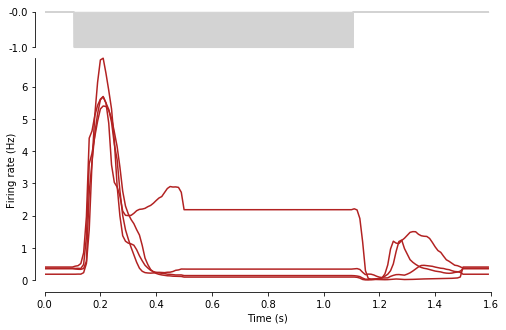

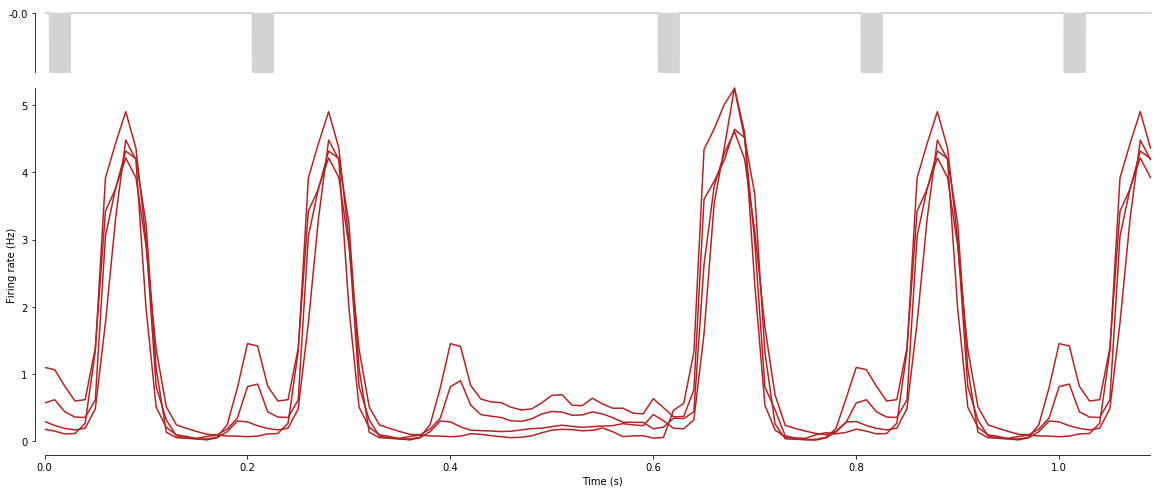

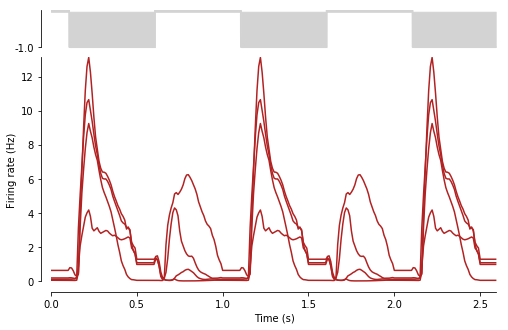

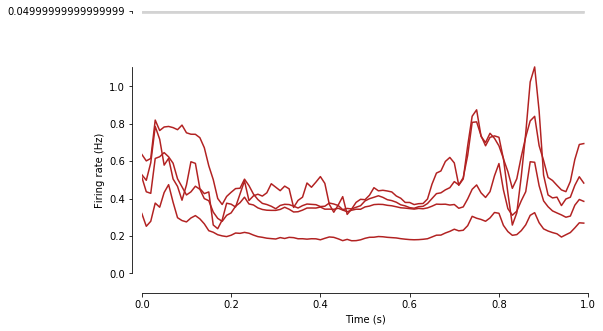

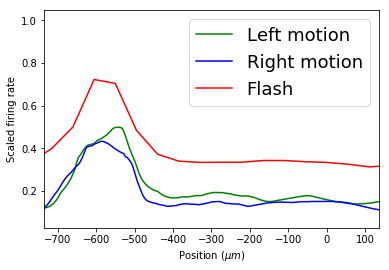

  0%|          | 0/10 [00:00<?, ?it/s]

For layer 4


100%|██████████| 10/10 [00:00<00:00, 87.38it/s]
51it [00:00, 220.74it/s]


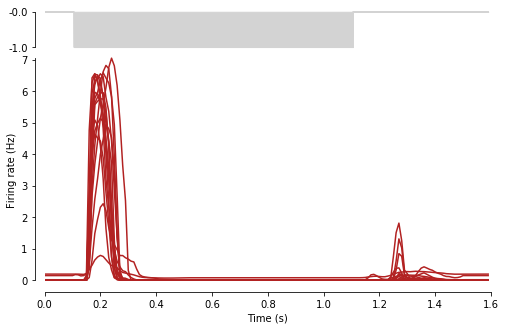

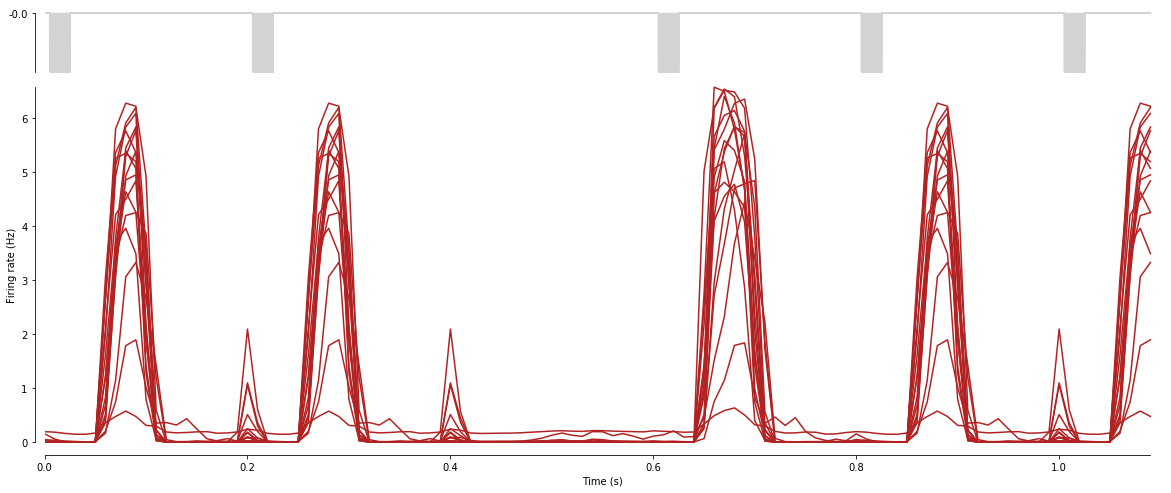

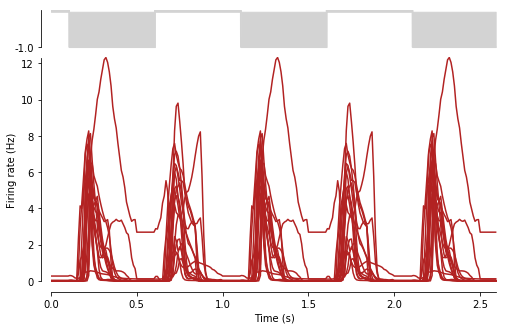

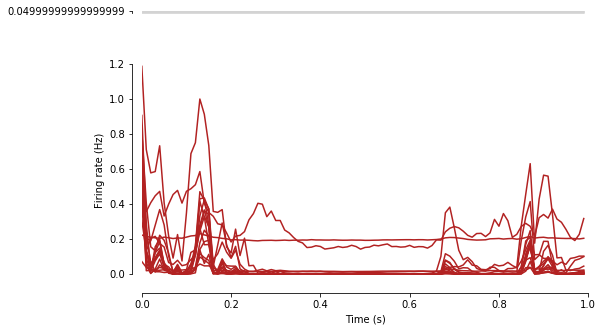

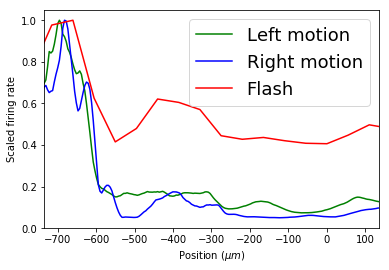

  0%|          | 0/10 [00:00<?, ?it/s]

For layer 5


100%|██████████| 10/10 [00:00<00:00, 87.04it/s]
51it [00:00, 214.62it/s]


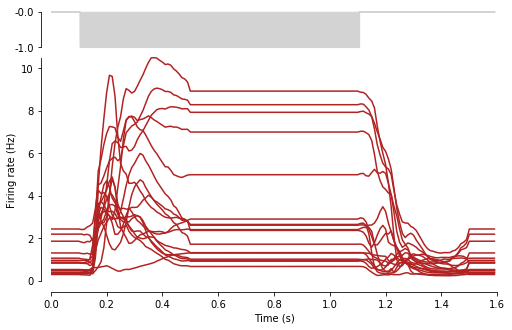

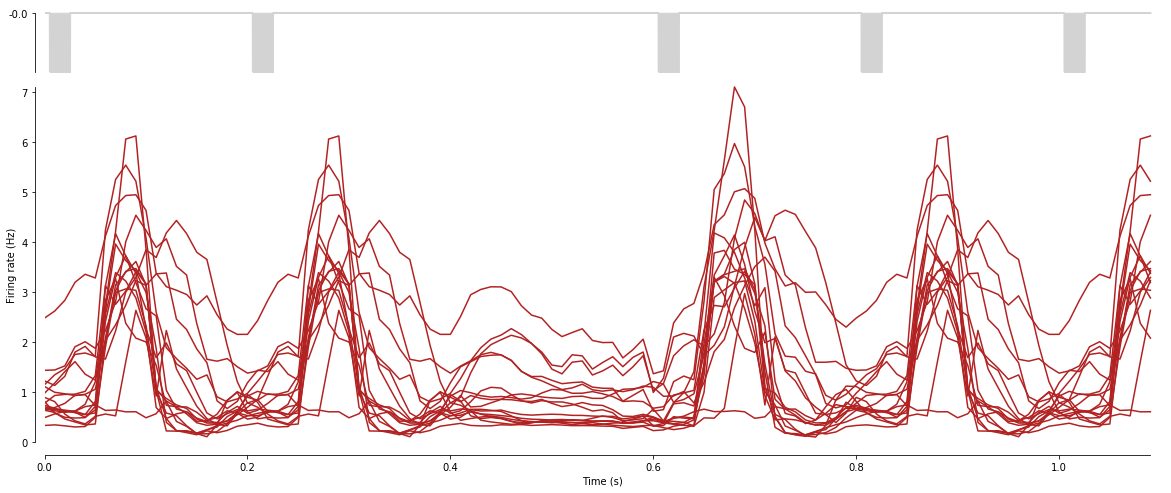

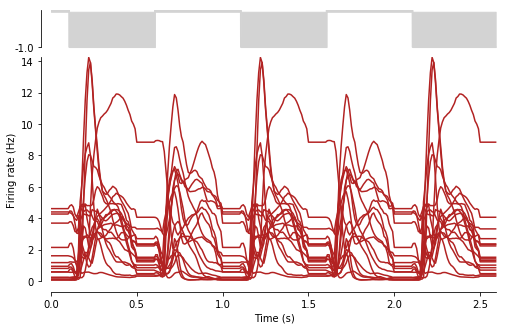

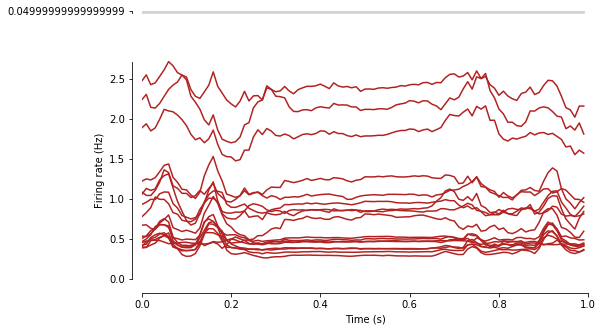

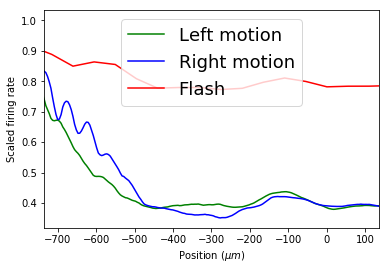

  0%|          | 0/6 [00:00<?, ?it/s]

Calculating model responses...



  0%|          | 0/6 [00:00<?, ?it/s]

Calculating intercellular correlations...



100%|██████████| 6/6 [02:24<00:00, 24.30s/it]


Mean intracellular: 0.4751975393654208
Std intracellular: 0.13532717014263101
Min intracellular: 0.162734996257619
Max intracellular: 0.7054611390093811
Layer 0.2 correlation map


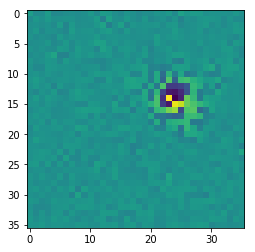

bipolar


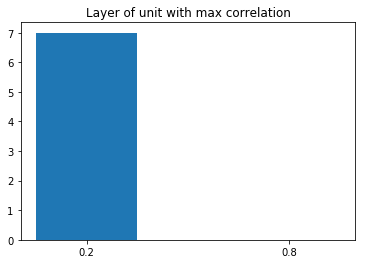

amacrine


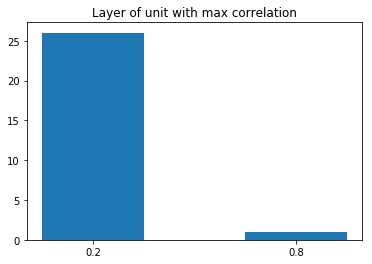

horizontal


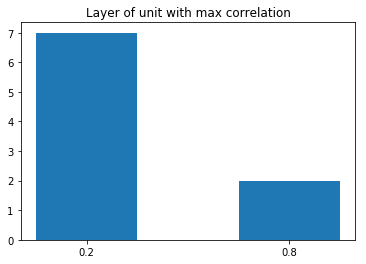

Receptive field of boxes model cell in Layer 0


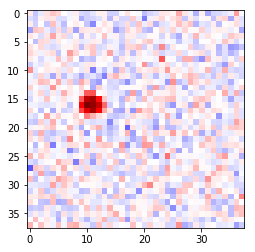

Receptive field of boxes model cell in Layer 1


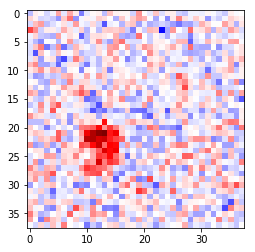

Memory Used: 8660.98 memory
Completed in 181.43885922431946 seconds





Folder: paralleldata_multidatabncnn/paralleldata_multidatabncnn_1_lr0.0075_l20.0005
Final Loss: -7.641191973360775
Final Vals: [-0.42301043811198724, -6.118891943669951, -3.2442713440314037, -10.925064308936271, -0.39137115493940655, -7.2564675415924285]
Final Val Acc: [0.19357520639896392, 0.2849440038204193, 0.23564796149730682, 0.2877897173166275, 0.20612623630201116, 0.24312270213575923]

Final Test Acc for 15-10-07 naturalscene: 0.3734471481500895

Final Test Acc for 15-10-07 whitenoise: 0.6892356721948248

Final Test Acc for 15-11-21a naturalscene: 0.5269134996184761

Final Test Acc for 15-11-21a whitenoise: 0.6297871464384647

Final Test Acc for 15-11-21b naturalscene: 0.4652235037707468

Final Test Acc for 15-11-21b whitenoise: 0.5370098413493497


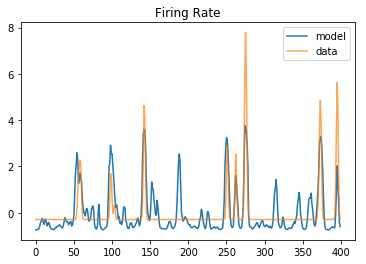

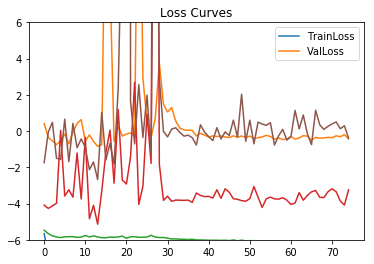

  0%|          | 0/10 [00:00<?, ?it/s]

For layer 0


100%|██████████| 10/10 [00:00<00:00, 83.08it/s]
51it [00:00, 207.82it/s]


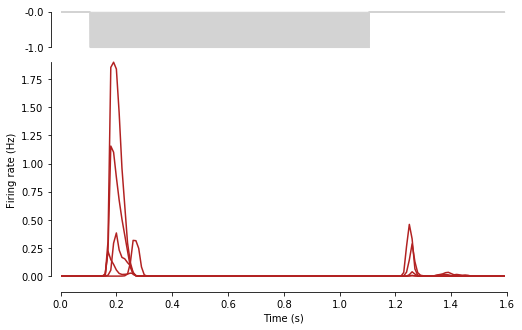

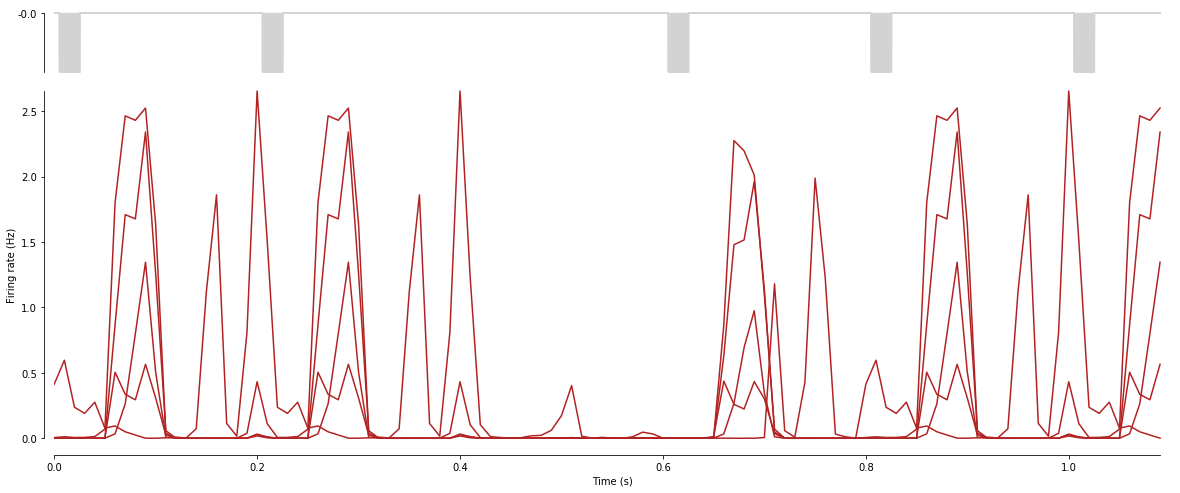

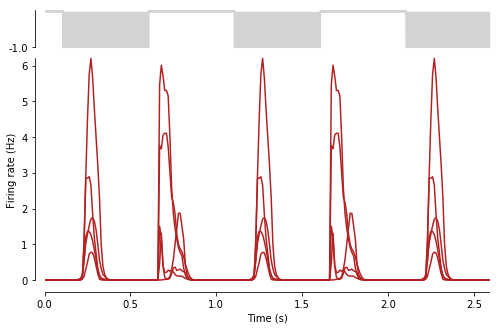

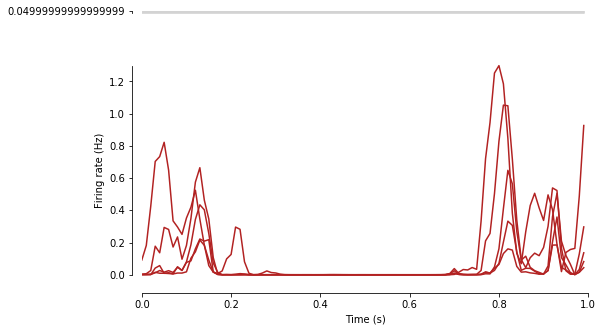

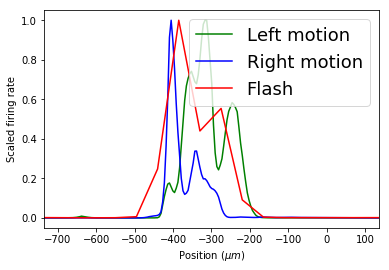

  0%|          | 0/10 [00:00<?, ?it/s]

For layer 1


100%|██████████| 10/10 [00:00<00:00, 81.87it/s]
51it [00:00, 212.44it/s]


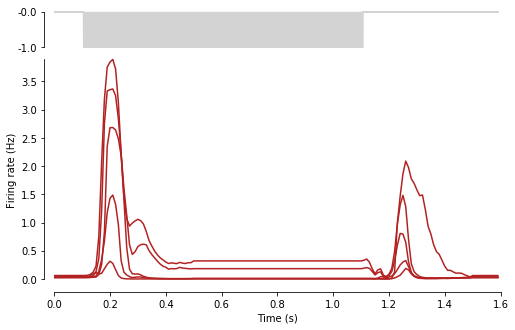

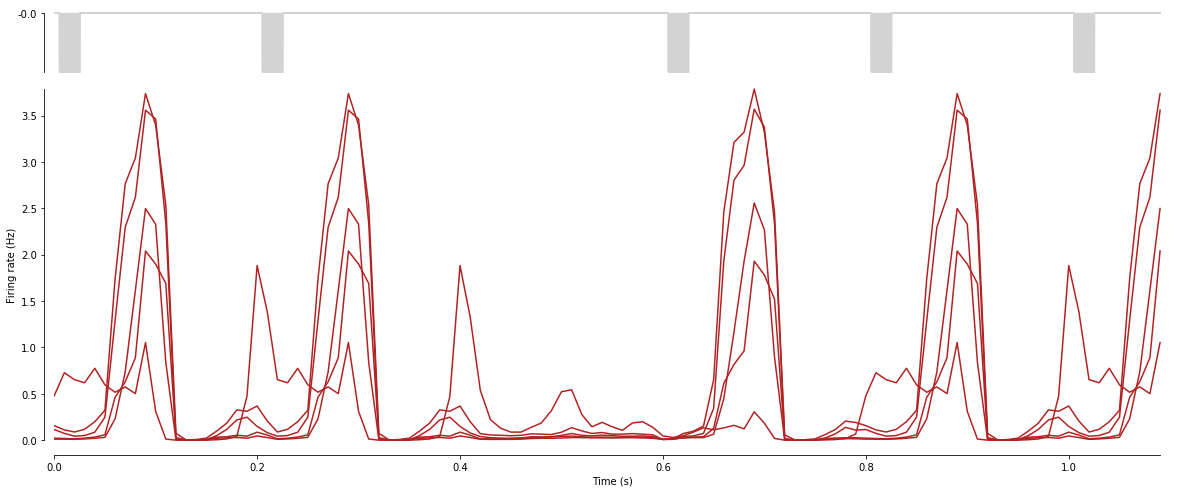

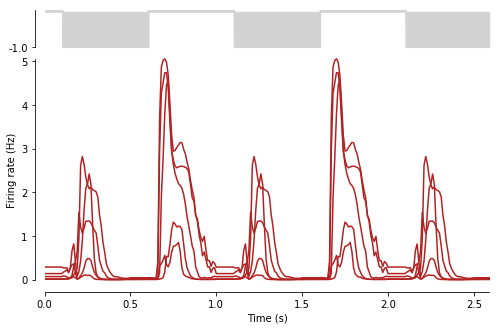

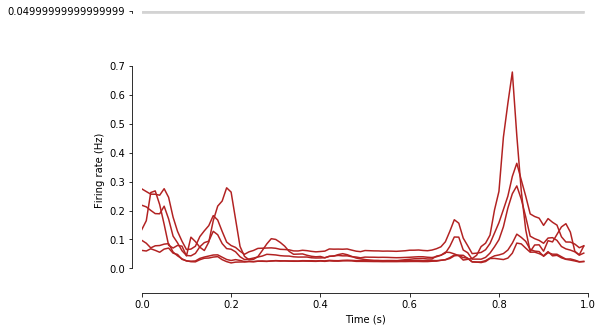

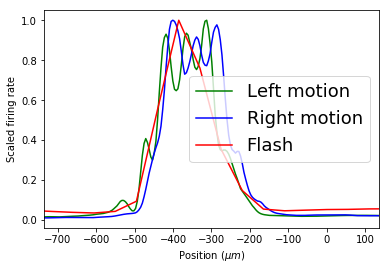

  0%|          | 0/10 [00:00<?, ?it/s]

For layer 2


100%|██████████| 10/10 [00:00<00:00, 84.28it/s]
51it [00:00, 211.07it/s]


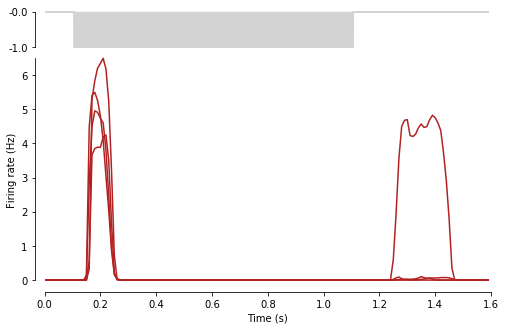

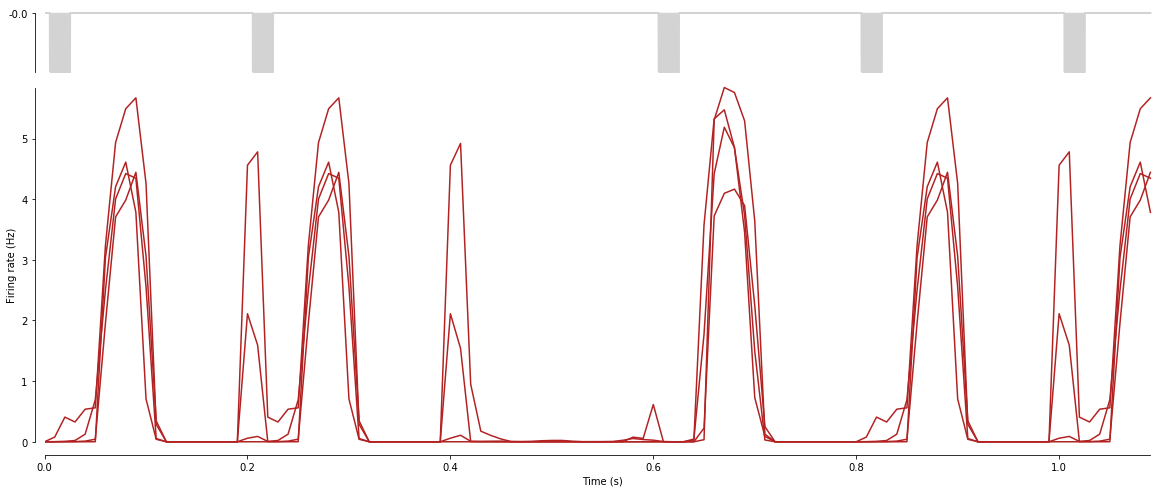

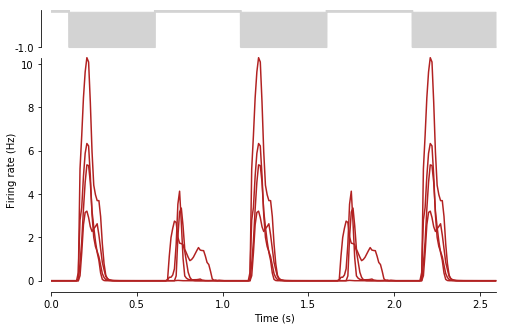

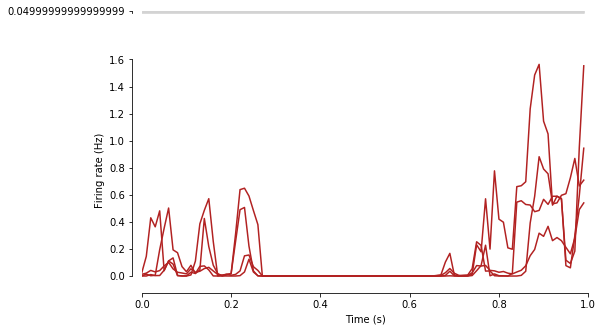

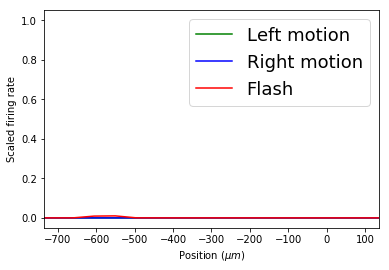

  0%|          | 0/10 [00:00<?, ?it/s]

For layer 3


100%|██████████| 10/10 [00:00<00:00, 84.66it/s]
51it [00:00, 209.22it/s]


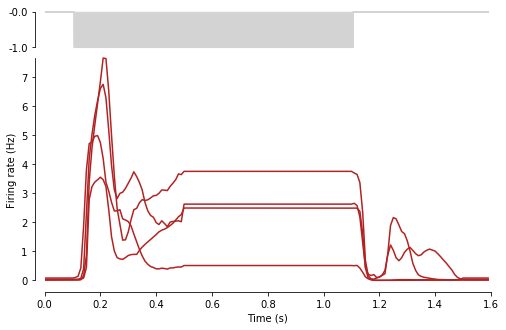

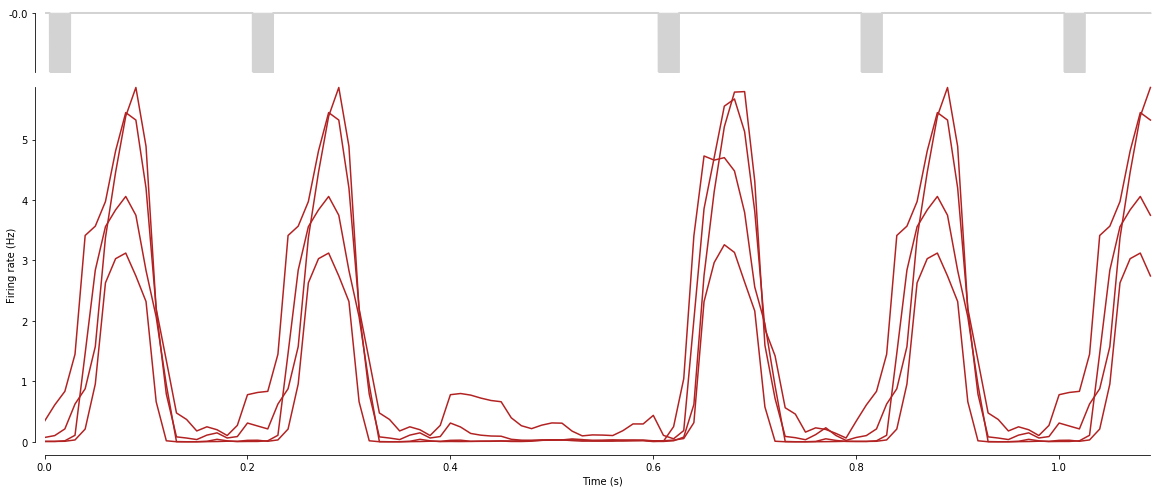

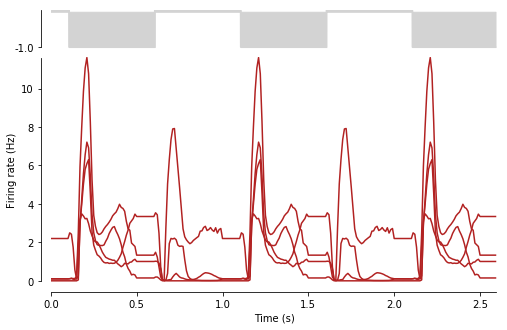

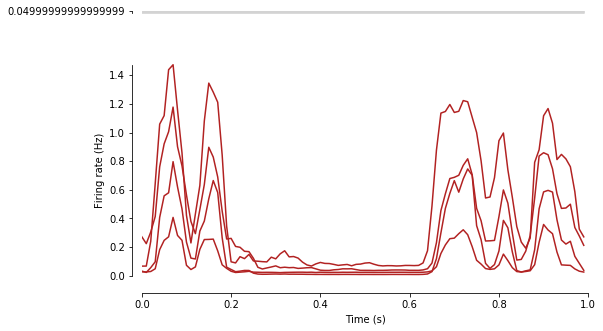

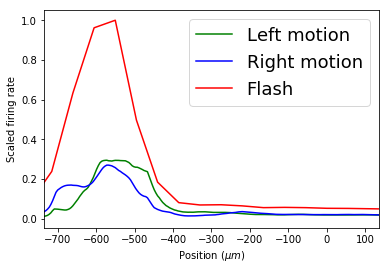

For layer 4


100%|██████████| 10/10 [00:00<00:00, 78.68it/s]
51it [00:00, 213.78it/s]


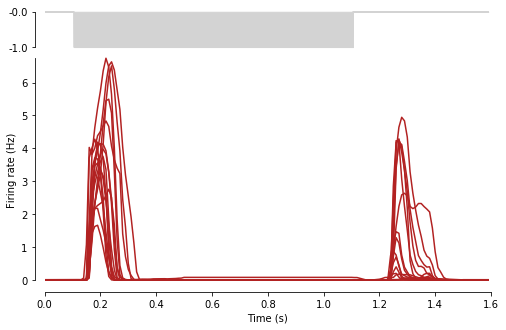

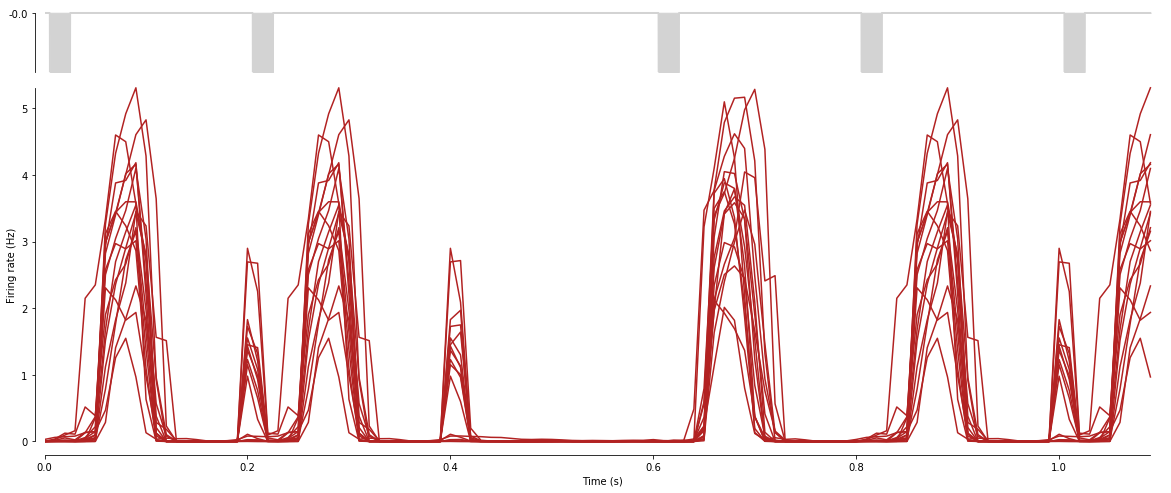

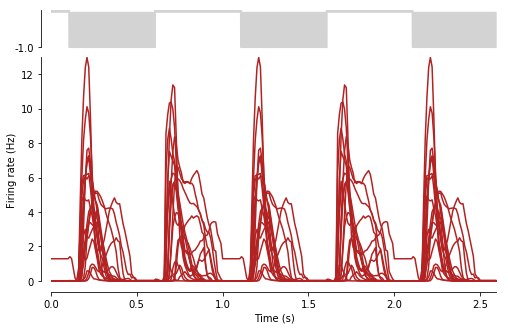

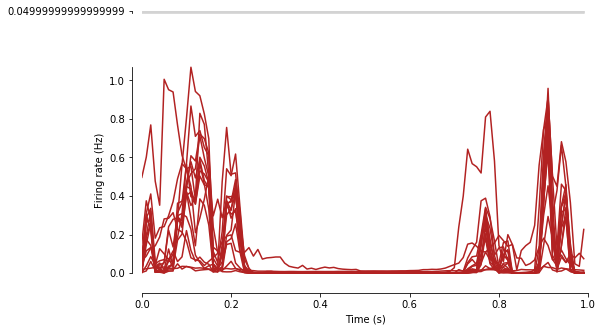

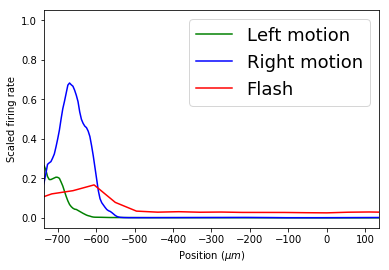

  0%|          | 0/10 [00:00<?, ?it/s]

For layer 5


100%|██████████| 10/10 [00:00<00:00, 84.36it/s]
51it [00:00, 216.46it/s]


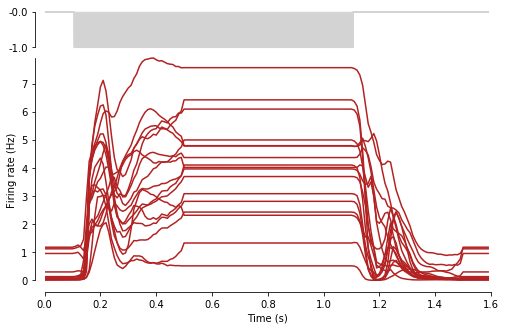

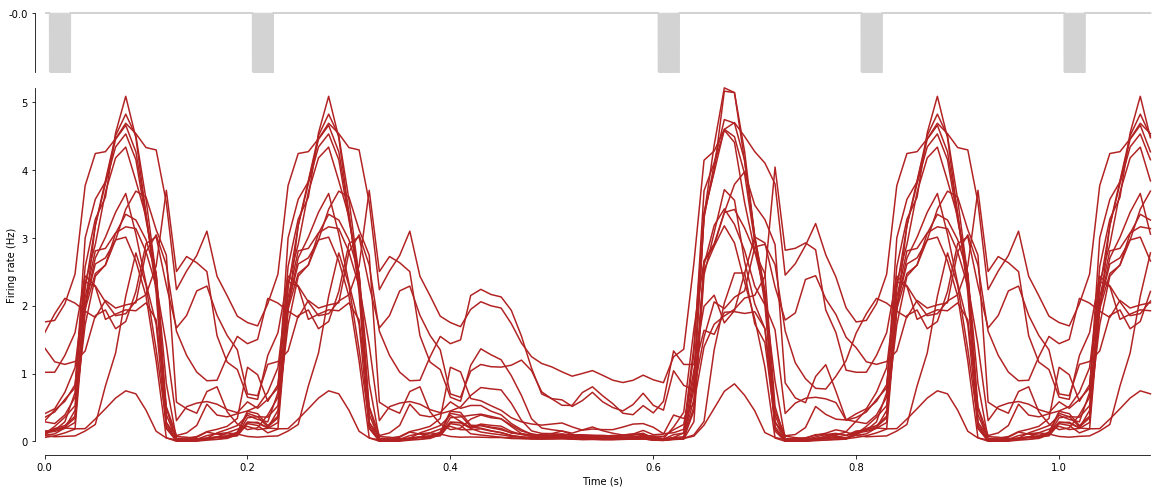

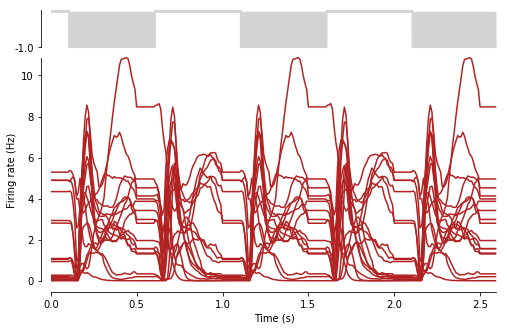

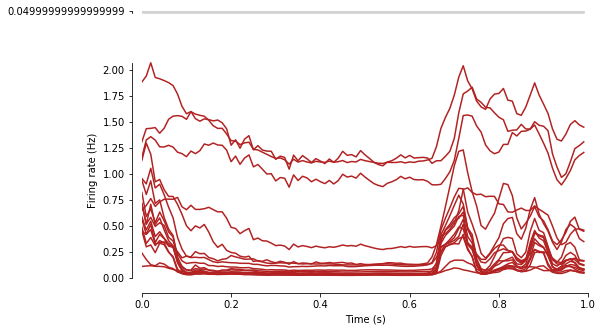

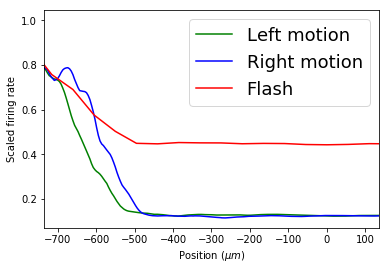

  0%|          | 0/6 [00:00<?, ?it/s]

Calculating model responses...



  0%|          | 0/6 [00:00<?, ?it/s]

Calculating intercellular correlations...



100%|██████████| 6/6 [02:30<00:00, 25.27s/it]


Mean intracellular: 0.48403655531697776
Std intracellular: 0.13266907166587574
Min intracellular: 0.19533794735867863
Max intracellular: 0.7419077548343218
Layer 0.2 correlation map


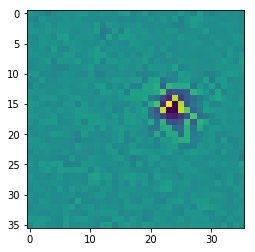

bipolar


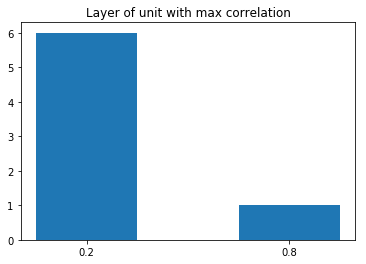

amacrine


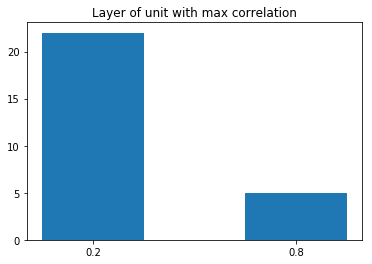

horizontal


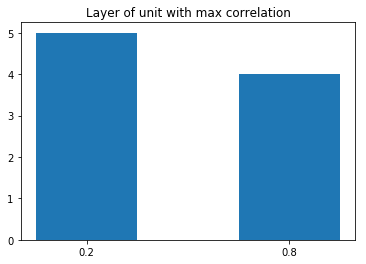

Receptive field of boxes model cell in Layer 0


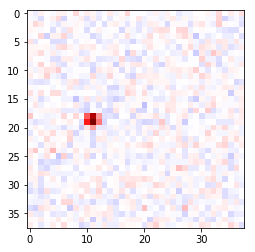

Receptive field of boxes model cell in Layer 1


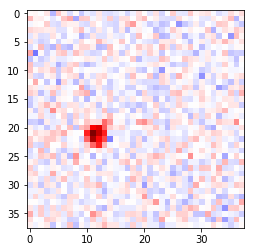

Memory Used: 8660.98 memory
Completed in 188.087899684906 seconds







In [46]:
n_epochs = 250

results_file_name = grand_folder + "_analysis_results.txt"
results_file = open(results_file_name, 'a')
batch_compute_size = 2000

# load the losses
print("Using layers:", " and ".join(conv_layers))
for folder in model_folders:
    starttime = time.time()
    losses = []
    val_losses = []
    val_accs = []
    for i in range(n_epochs):
        file = "../training_scripts/"+folder+"/test_epoch_{0}.pth".format(i)
        try:
            with open(file, "rb") as fd:
                temp = torch.load(fd)
            losses.append(temp['loss'])
            val_losses.append(temp['val_losses'])
            val_accs.append(temp['val_accs'])
        except:
            break
    bn_cnn = temp['model']
    bn_cnn = bn_cnn.to(DEVICE)
    bn_cnn.eval()
    print("Folder:", folder)
    results_file.write(folder + "\n")
    print("Final Loss:", losses[-1])
    results_file.write("Final Loss:"+ str(losses[-1]) + "\n")
    print("Final Vals:", val_losses[-1])
    results_file.write("Final Val:"+ str(val_losses[-1]) + "\n")
    print("Final Val Acc:", val_accs[-1])
    results_file.write("Val Acc:"+ str(val_accs[-1]) + "\n")
    if(math.isnan(losses[-1]) or math.isnan(np.mean(val_losses[-1])) or math.isnan(np.mean(val_accs[-1]))):
        print("NaN results, continuing...\n\n\n\n")
        results_file.write("NaN results, continuing...\n\n\n\n")
        continue
    
    nan_occurred = False
    count = 0
    for dataset, cell in zip(datasets, cells):
        for stim_type in stim_types:
            test_data = loadexpt(dataset,cell,stim_type,'test',40,0, norm_stats=norm_stats)
            test_x = torch.from_numpy(test_data.X)
            temp_model = nn.Sequential(bn_cnn.features, bn_cnn.output_layers[count])
            count += 1
            model_response = bc.batch_compute_model_response(test_data.X, temp_model, batch_compute_size, 
                                                             insp_keys=set(conv_layers))    
            avg_test_acc = np.mean([scipy.stats.pearsonr(model_response['output'][:, i], test_data.y[:, i])[0] 
                                    for i in range(test_data.y.shape[-1])])
            if math.isnan(avg_test_acc):
                nan_occurred = True
            print("\nFinal Test Acc for "+dataset+" "+stim_type+":", avg_test_acc)
            results_file.write("Final Test Acc for "+dataset+" "+stim_type+":"+ str(avg_test_acc) + "\n")
            with open("../training_scripts/"+folder+"/hyperparams.txt", 'a') as f:
                f.write("\nTest  for "+dataset+" "+stim_type+":" + str(avg_test_acc))
    if nan_occurred:
        print("NaN results, continuing...\n\n\n\n")
        results_file.write("NaN results, continuing...\n\n\n\n")

    plt.plot(normalize(model_response['output'][:400, 0]))
    plt.plot(normalize(test_data.y[:400,0]), alpha=.7)
    plt.legend(["model", "data"])
    plt.title("Firing Rate")
    plt.show()
    plt.plot(losses)
    plt.plot(np.arange(0,len(val_losses)), val_losses)
    plt.legend(["TrainLoss", "ValLoss"])
    plt.title("Loss Curves")
    plt.ylim([-6, 6])
    plt.show()
    for i,output_layer in enumerate(bn_cnn.output_layers):
        print("For layer", i)
        temp_model = nn.Sequential(bn_cnn.features, output_layer)
        retinal_phenomena_figs(temp_model)
        plt.show()
    
    
    print("Calculating model responses...\n")
    # Computes the model responses for each stimulus 
    # and interneuron type labels y_true (0 for bipolar, 1 for amacrine, 2 for horizontal)
    y_true = []
    filter_length = 40
    model_responses = dict()
    for i in tqdm(range(len(files))):
        file_name = files[i]
        if 'bipolar' in file_name:
            for j in range(num_pots[i]):
                y_true.append(0)
        elif 'amacrine' in file_name:
            for j in range(num_pots[i]):
                y_true.append(1)
        else:
            for j in range(num_pots[i]):
                y_true.append(2)
        for k in stims.keys():
            stim = stims[k][i]
            padded_stim = intracellular.pad_to_edge(scipy.stats.zscore(stim))
            if k not in model_responses:
                model_responses[k] = []
            temp_model = nn.Sequential(bn_cnn.features, bn_cnn.output_layers[0])
            model_responses[k].append(bc.batch_compute_model_response(stimuli.concat(padded_stim),
                                                                      temp_model,batch_compute_size, 
                                                                      insp_keys=set(conv_layers)))
            # Reshape potentially flat layers
            for j,cl in enumerate(conv_layers):
                if len(model_responses[k][-1][cl].shape) <= 2:
                    try:
                        model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,8,36,36))
                    except:
                        model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,8,26,26))
    
    # uses classify to get the most correlated cell/layer/subtype for each interneuron recording. 
    # Stored in all_cell_info. y_pred does a baseline "classification": record the convolutional 
    # layer that the most correlated cell is in.
    # See intracellular.py for more info
    # This takes a really long time to run. 
    print("Calculating intercellular correlations...\n")
    all_cell_info = dict()
    y_pred = dict()
    for i in tqdm(range(len(files))):
        for k in stims.keys():
            model_response = model_responses[k][i]
            stim = stims[k][i]
            for j in range(mem_pots[k][i].shape[0]):
                potential = mem_pots[k][i][j]
                cell_info = intracellular.classify(potential, model_response, stim.shape[0], 
                                                   layer_keys=conv_layers)
                #layer, channel,(row, col), cor_coef = cell_info
                if k not in all_cell_info:
                    all_cell_info[k] = []
                    y_pred[k] = []
                all_cell_info[k].append(cell_info)
                y_pred[k].append(index_of(cell_info[0], conv_layers))
            
    # Average intracellular correlation. RIP.
    avg_intr_cor = np.mean(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Mean intracellular:", avg_intr_cor)
    results_file.write("Mean intracellular:" + str(avg_intr_cor) + "\n")
    std = np.std(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Std intracellular:", std)
    m = np.min(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Min intracellular:", m)
    results_file.write("Min intracellular:" + str(m) + "\n")
    m = np.max(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Max intracellular:", m)
    results_file.write("Max intracellular:" + str(m) + "\n")
    
    stim_type = 'boxes'
    # Make example correlation map
    model_response = model_responses[stim_type][-1]
    potential = mem_pots[stim_type][-1][-1]
    layer, k, (i,j), r = all_cell_info[stim_type][-1]
    print("Layer", layer, "correlation map")
    plt.imshow(intracellular.correlation_map(potential, model_response[layer][:, k]))
    plt.show()

    keys = ['bipolar', 'amacrine', 'horizontal']
    layer_dict = {}
    # Tally layers for maximally correlated cell
    for i in range(len(y_true)):
        if y_true[i] not in layer_dict:
            layer_dict[y_true[i]] = [0 for i in range(len(conv_layers))]
        for k in y_pred.keys():
            layer_dict[y_true[i]][y_pred[k][i]] += 1

    width = 0.5
    lkeys = list(layer_dict.keys())
    ind = np.arange(0,len(conv_layers))
    for i,k in enumerate(lkeys):
        plt.bar(ind, [count for count in layer_dict[k]], width)
        plt.xticks(ind,conv_layers)
        print(keys[i])
        plt.title("Layer of unit with max correlation")
        plt.show()
    
    stimulus_num = 3
    filter_length = 40
    for type_key in stims.keys():
        if type_key == "flashes":
            continue
        stimulus = stims[type_key][stimulus_num]
        # Plot the receptive field for a model cell
        for i,cl in enumerate(conv_layers):
            model_cell_response = model_responses[type_key][stimulus_num][cl][:, 1, 15, 15]
            print("Receptive field of", type_key,"model cell in Layer", i)
            rc_model, lags_model = ft.revcorr(scipy.stats.zscore(stimulus)[filter_length:], model_cell_response, 
                                              nsamples_before=0, nsamples_after=filter_length)
            spatial_model, temporal_model = ft.decompose(rc_model)
            img = plt.imshow(spatial_model, cmap = 'seismic', clim=[-np.max(abs(spatial_model)), 
                                                                   np.max(abs(spatial_model))])
            plt.show()
    
    gc.collect()
    max_mem_used = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    print("Memory Used: {:.2f} memory".format(max_mem_used / 1024))
    print("Completed in", time.time()-starttime, "seconds")
    print("\n\n\n\n")
    results_file.write("\n\n\n\n")
                    
results_file.close()


## Closer Look at Intracellular Correlations

In [ ]:
# Look more closely at intracellular correlations
for i in range(250):
    file = "../training_scripts/"+best_folder_by_intr_cor+"/test_epoch_{0}.pth".format(i)
    try:
        with open(file, "rb") as fd:
            temp = torch.load(fd)
    except:
        break
bn_cnn = temp['model']
# bn_cnn.load_state_dict(temp['model_state_dict']) # unnecessary
bn_cnn.to(DEVICE)
bn_cnn.eval()
# Computes the model responses for each stimulus 
# and interneuron type labels y_true (0 for bipolar, 1 for amacrine, 2 for horizontal)
y_true = []
filter_length = 40
model_responses = dict()
for i in tqdm(range(len(files))):
    file_name = files[i]
    if 'bipolar' in file_name:
        for j in range(num_pots[i]):
            y_true.append(0)
    elif 'amacrine' in file_name:
        for j in range(num_pots[i]):
            y_true.append(1)
    else:
        for j in range(num_pots[i]):
            y_true.append(2)
    for k in stims.keys():
        stim = stims[k][i]
        padded_stim = intracellular.pad_to_edge(scipy.stats.zscore(stim))
        if k not in model_responses:
            model_responses[k] = []
        model_responses[k].append(bc.batch_compute_model_response(stimuli.concat(padded_stim),
                                                                  bn_cnn,batch_compute_size, 
                                                                  insp_keys=set(conv_layers)))
        # Reshape potentially flat layers
        for j,cl in enumerate(conv_layers):
            if len(model_responses[k][-1][cl].shape) <= 2:
                try:
                    model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,8,36,36))
                except:
                    model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,8,26,26))

# uses classify to get the most correlated cell/layer/subtype for each interneuron recording. 
# Stored in all_cell_info. y_pred does a baseline "classification": record the convolutional 
# layer that the most correlated cell is in.
# See intracellular.py for more info
# This takes a really long time to run. 
print("Calculating intercellular correlations...")
all_cell_info = dict()
y_pred = dict()
for i in tqdm(range(len(files))):
    for k in stims.keys():
        model_response = model_responses[k][i]
        stim = stims[k][i]
        for j in range(mem_pots[k][i].shape[0]):
            potential = mem_pots[k][i][j]
            cell_info = intracellular.classify(potential, model_response, stim.shape[0], 
                                               layer_keys=conv_layers)
            #layer, channel,(row, col), cor_coef = cell_info
            if k not in all_cell_info:
                all_cell_info[k] = []
                y_pred[k] = []
            all_cell_info[k].append(cell_info)
            y_pred[k].append(index_of(cell_info[0], conv_layers))

duplicates = {}
for k in all_cell_info.keys():
    idx = 0
    for i in range(len(mem_pots)):
        for j,pot in enumerate(mem_pots[k][i]):
            layer, channel,(row, col), cor_coef = all_cell_info[k][idx]
            tup = (layer, channel, row, col)
            if tup not in duplicates:
                duplicates[tup] = 1
            else:
                duplicates[tup] += 1
            cor = np.correlate(model_responses[k][i][layer][:,channel, row, col], pot, 'full')
            print("i:", i, " - j:", j)
            print("Layer:", layer, " - Channel:", channel, " - Row:", row, " - Col:", col)
            print("Pearsonr:", cor_coef)
            plt.plot(cor)
            plt.title("Correlation")
            plt.show()
            plt.plot(normalize(model_responses[k][i][layer][:400, channel,row,col]))
            plt.plot(normalize(mem_pots[k][i][j][:400]), alpha=.7)
            plt.legend(["model", "data"])
            plt.title("Firing Rate")
            plt.show()
            print("\n\n")
            idx+=1